# Avant de lancer ce code, on doit avoir:
- OUTDIR/X_train_z.npy
- OUTDIR/X_test_z.npy
- OUTDIR/meta_train_postQC.csv (avec patient_id)

- X_*_z = matrice samples × genes standardisée (après sélection top-variance)


Structure:
1.	Imports/seed
2.	Charger X_all et X_test + split X_tr/X_val (float32)
3.	Build AE
4.	Fit AE (arrays)
5.	Eval + latent AE
6.	Build VAE
7.	Fit VAE (arrays, validation_data=(X_val,))
8.	Eval + latent VAE
9.	Save models

# ENTRAINEMENT AE
## AE preprocess
### Import et seed

In [71]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd

SEED = 42
tf.keras.utils.set_random_seed(SEED)

### Charger les matrices issue du préprocess

In [81]:
OUTDIR = "./tcga_brca_repr"
os.makedirs(OUTDIR, exist_ok=True)
# X_train_z vient du QC
X_all = np.load("./tcga_brca_qc_report/X_train_z.npy")  # shape: (n_train, n_features)
X_test  = np.load("./tcga_brca_qc_report/X_test_z.npy")

n = X_all.shape[0]
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

val_frac = 0.15  # 10–20% est standard
n_val = int(val_frac * n)

val_idx = idx[:n_val]
tr_idx  = idx[n_val:]

X_train  = X_all[tr_idx]
X_val = X_all[val_idx]

meta_all = pd.read_csv("./tcga_brca_qc_report/meta_train_postQC.csv")

meta_tr_split  = meta_all.iloc[tr_idx].reset_index(drop=True)
meta_val_split = meta_all.iloc[val_idx].reset_index(drop=True)

assert meta_tr_split.shape[0] == X_train.shape[0]

# AE: arrays propres
X_tr  = np.asarray(X_train, dtype=np.float32)
X_val = np.asarray(X_val, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)


print("X_train:", X_train.shape, "X_test:", X_test.shape, "X_val:", X_val.shape)
print("dtype check:", X_train.dtype, X_test.dtype, X_val.dtype)

X_train: (692, 10000) X_test: (208, 10000) X_val: (122, 10000)
dtype check: float64 float32 float32


In [ ]:
# Aligner méta
# -----------------------------------------------------
# IDs alignés avec Z_train_ae / Z_test_ae (sans .index)

ID_COL = "submitter_id"

# ---- TRAIN: meta_tr_split est déjà aligné avec X_train donc avec Z_train_ae ----
assert len(meta_tr_split) == Z_train_ae.shape[0], (
    f"train mismatch: meta_tr_split={len(meta_tr_split)} vs Z_train={Z_train_ae.shape[0]}"
)
ids_train = meta_tr_split[ID_COL].astype(str).values
np.save(os.path.join(OUTDIR, "ids_train_AE.npy"), ids_train)

# ---- TEST: on recharge la meta test qui correspond à X_test/Z_test ----
meta_te = pd.read_csv("./tcga_brca_qc_report/meta_test_postQC.csv")

assert len(meta_te) == Z_test_ae.shape[0], (
    f"test mismatch: meta_te={len(meta_te)} vs Z_test={Z_test_ae.shape[0]}"
)
ids_test = meta_te[ID_COL].astype(str).values
np.save(os.path.join(OUTDIR, "ids_test_AE.npy"), ids_test)

print("Saved as ids_train_AE.npy / ids_test_AE.npy")

Saved as ids_train_AE.npy / ids_test_AE.npy


## AE = baseline
### Construire AE

In [74]:
n_features = X_train.shape[1]
LATENT_DIM = 32

inputs = keras.Input(shape=(n_features,))
x = layers.Dense(512, activation="relu")(inputs)
x = layers.Dense(256, activation="relu")(x)
z = layers.Dense(LATENT_DIM, name="z")(x)

x = layers.Dense(256, activation="relu")(z)
x = layers.Dense(512, activation="relu")(x)
outputs = layers.Dense(n_features, name="recon")(x)

ae = keras.Model(inputs, outputs, name="AE")
ae.compile(optimizer=keras.optimizers.Adam(1e-4), loss="mse")
ae.summary()

Model: "AE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 512)            │     5,120,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z (Dense)                       │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ recon (Dense)                   │ (None, 10000)          │     5,130,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,530,096 (40.17 MB)

 Trainable params: 10,530,096 (40.17 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
import numpy as np

print("X_tr shape:", X_tr.shape, "dtype:", X_tr.dtype)
print("NaN:", np.isnan(X_tr).sum(), "Inf:", np.isinf(X_tr).sum())
print("min/max:", float(np.min(X_tr)), float(np.max(X_tr)))
print("mean/std:", float(np.mean(X_tr)), float(np.std(X_tr)))

X_tr shape: (692, 10000) dtype: float32
NaN: 0 Inf: 0
min/max: -2.590519428253174 28.512907028198242
mean/std: 0.0048123812302947044 1.0083996057510376


### Entraîner AE
Un autoencoder apprend à reconstruire l’entrée. Donc la cible y = l’entrée x.
Dans certaines versions Keras, laisser y implicite n’est plus accepté → None values not supported.
Si le AE reconstruction loss est mauvais, jouer sur LR pour obtenir quelque chose de correct

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 1.0359 - val_loss: 0.8683 - learning_rate: 1.0000e-04
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8872 - val_loss: 0.7586 - learning_rate: 1.0000e-04
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7755 - val_loss: 0.7001 - learning_rate: 1.0000e-04
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7065 - val_loss: 0.6557 - learning_rate: 1.0000e-04
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6639 - val_loss: 0.6332 - learning_rate: 1.0000e-04
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6420 - val_loss: 0.6192 - learning_rate: 1.0000e-04
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.6264 - val_loss: 0.6042 - learning_rate: 1.0000e-04
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6115 - val_loss: 0.5927 - learning_rate: 1.0000e-04
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.5972 - val_loss: 0.5809 - 

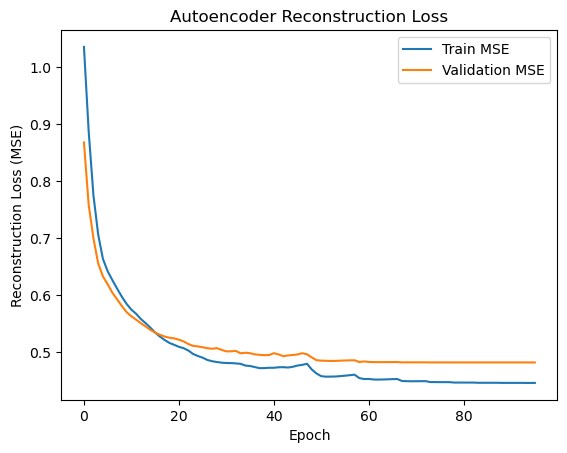

In [76]:
callbacks_ae = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5),
]

hist_ae = ae.fit(
    X_tr, X_tr,
    validation_data=(X_val, X_val),
    epochs=200,
    batch_size=64,
    callbacks=callbacks_ae,
    verbose=1
)
import matplotlib.pyplot as plt

# Récupération des pertes
train_loss = hist_ae.history["loss"]
val_loss   = hist_ae.history.get("val_loss", None)

plt.figure()
plt.plot(train_loss, label="Train MSE")

if val_loss is not None:
    plt.plot(val_loss, label="Validation MSE")

plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss (MSE)")
plt.title("Autoencoder Reconstruction Loss")
plt.legend()
plt.show()

### Evaluer AE et extraire latent space
Un AE est un modèle supervisé “trivial” :
	•	entrée = x
	•	cible = x (on reconstruit l’entrée)
    Keras attend des batch du type (x,x)

In [77]:
ae_test_mse = ae.evaluate(X_test, X_test, batch_size=256, verbose=1)
print("AE test MSE:", ae_test_mse)

encoder_ae = keras.Model(ae.input, ae.get_layer("z").output, name="encoder_ae")
Z_train_ae = encoder_ae.predict(X_train.astype(np.float32), batch_size=256)
Z_test_ae  = encoder_ae.predict(X_test.astype(np.float32), batch_size=256)

np.save(os.path.join(OUTDIR, "Z_train_AE.npy"), Z_train_ae)
np.save(os.path.join(OUTDIR, "Z_test_AE.npy"), Z_test_ae)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.6053
AE test MSE: 0.6053369641304016
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


# PCA du latent space

In [78]:
# Cellule — PCA sur le latent (fit sur TRAIN uniquement, transform TEST)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca_latent = PCA(n_components=2, random_state=42)
Ztr_2d = pca_latent.fit_transform(Z_train_ae)
Zte_2d = pca_latent.transform(Z_test_ae)

print("Explained variance (PC1, PC2):", pca_latent.explained_variance_ratio_)

Explained variance (PC1, PC2): [0.33772132 0.23109068]


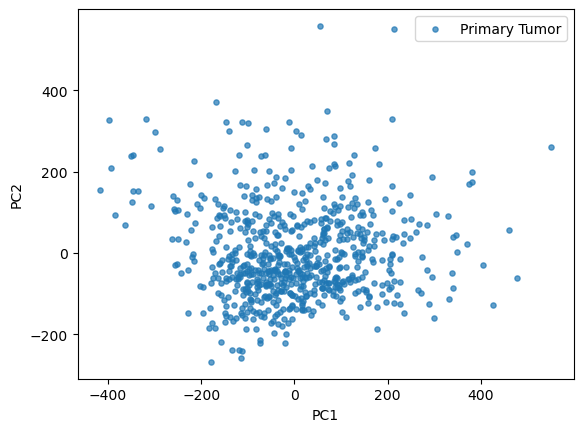

In [79]:
col = "sample_type"  # adapte au vrai nom de colonne
plt.figure()
for g in meta_tr_split[col].astype(str).unique():
    m = (meta_tr_split[col].astype(str).values == g)
    plt.scatter(Ztr_2d[m, 0], Ztr_2d[m, 1], s=14, alpha=0.7, label=str(g))
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.show()